## Dr schäuscht Wäg zum Bähnli

Die Verkehrssituation auf dem Bödeli rund um Interlaken ist ziemlich verfahren. Abhilfe könnte ein neuer Zentralbahnhof am heutigen Standort des Jungfrau-Parks schaffen. Doch wie gut wäre der neue Bahnhof Mystery erreichbar? 

Um das herauszufinden, werden mit dem untenstehenden Skript in der Programmiersprache Python die Daten der rund 10 400 auf [Openstreetmap](https://www.openstreetmap.org) verzeichneten Häuser von  Interlaken, Wilderswil, Bönigen, Unterseen, Ringgenberg, Matten und Gsteigwiler heruntergeladen – unabhängig davon, ob es sich um Wohnhäuser, Gewerbebauten oder Ställe handelt. In einem zweiten Schritt wird von jedem Haus aus der kürzeste Weg zu den beiden Bahnhöfen sowie zum vorgeschlagenen neuen Standort errechnet. Berücksichtigt werden alle Wege und Strassen; es wird nicht zwischen Fuss- und Velowegen sowie Autostrassen unterschieden. Nicht einbezogen werden die Topografie, das Verkehrsaufkommen sowie andere Verkehrseinschränkungen.

In [1]:
# Importieren der nötigen Bibliotheken. 

# Allegemeines.
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import tqdm

# Für die Karte und die Berechnungen
import osmnx as ox
import networkx as nx

# Fürs Zeichnen von Karten.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# Zur Verwaltung der Daten
import pandas as pd
import geopandas as gpd

In [2]:
# Voreinstellungen. 

# Definieren der nötigen Koordinaten. 
interlaken = (46.6849, 7.8581)
mystery = [46.68196, 7.87768]
westbahnhof = [46.6826487, 7.8515809]
ostbahnhof = [46.6904478, 7.8689965]
              
# Definieren der Gemeinden, die in die Berechnung einbezogen werden sollen.
places = ['Interlaken, Bern, Switzerland', 
          'Wilderswil, Bern, Switzerland',
          'Bönigen, Bern, Switzerland',
          'Unterseen, Bern, Switzerland',
          'Ringgenberg (BE), Bern, Switzerland',
          'Matten bei Interlaken, Bern, Switzerland',
          'Gsteigwiler, Bern, Switzerland']

In [3]:
# Herunterladen der Daten
G = ox.graph_from_place(places, network_type='all_private', simplify=True)

In [4]:
# Für jeden Bahnhof wird der nächste Punkt auf einer Strasse berechnet. 
closest_node_to_mystery = ox.get_nearest_node(G, mystery)
closest_node_to_westbahnhof = ox.utils.get_nearest_node(G, westbahnhof)
closest_node_to_ostbahnhof = ox.utils.get_nearest_node(G, ostbahnhof)

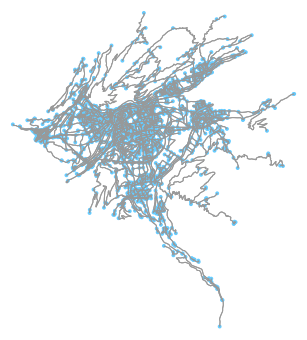

In [5]:
# Ein erster Blick auf die Karte. 
fig, ax = ox.plot_graph(G, save=True, filename='places')

In [6]:
# Die Informationen zu den Gebäuden in den ausgewählten Gemeinden werden heruntergeladen. 
df_gebäude = gpd.GeoDataFrame()
for p in places:
    df_gebäude = gpd.GeoDataFrame.append(df_gebäude, ox.buildings_from_place(p))
df_gebäude['zentrum'] = df_gebäude['geometry'].centroid
df_gebäude = df_gebäude.reset_index()

In [7]:
# Ein erster Blick auf die Daten der Bauten. 
df_gebäude.head()

,index,Wilderswil,access,addr:city,addr:country,addr:housename,addr:housenumber,addr:place,addr:postcode,addr:state,...,uic_ref,unisex,url,waterway,website,wheelchair,wheelchair:description,wikidata,wikipedia,zentrum
0,75126611,NaN,NaN,Interlaken,CH,NaN,1,NaN,3800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (7.850857063689771 46.68315205641377)
1,77103902,NaN,NaN,Interlaken,CH,NaN,1,NaN,3800,NaN,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,POINT (7.852216032665059 46.68163585393115)
2,81294669,NaN,NaN,Unterseen,CH,NaN,13,NaN,3800,NaN,...,NaN,NaN,NaN,weir,NaN,NaN,NaN,NaN,NaN,POINT (7.852524626224199 46.6878025756984)
3,144556744,NaN,NaN,Interlaken,CH,NaN,28,NaN,3800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (7.851543348123473 46.68254388616965)
4,144770786,NaN,NaN,Interlaken,CH,NaN,29,NaN,3800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (7.854559205537513 46.68163246518183)


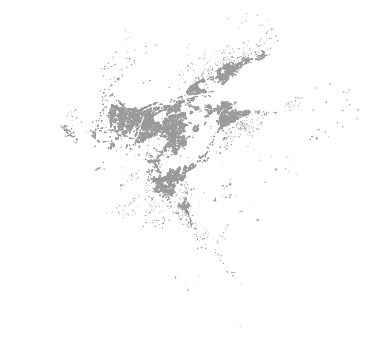

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe85c67ed68>)

In [8]:
# Ein erster Blick auf die Bautenkarte. 
ox.plot_shape(ox.project_gdf(df_gebäude))

100

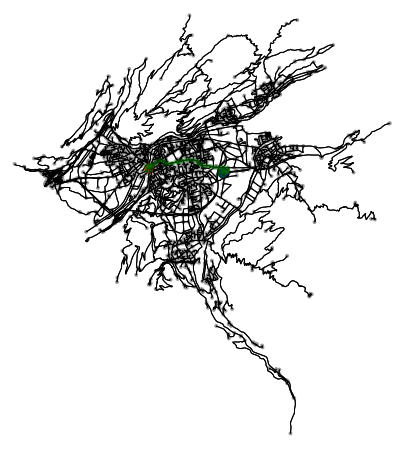

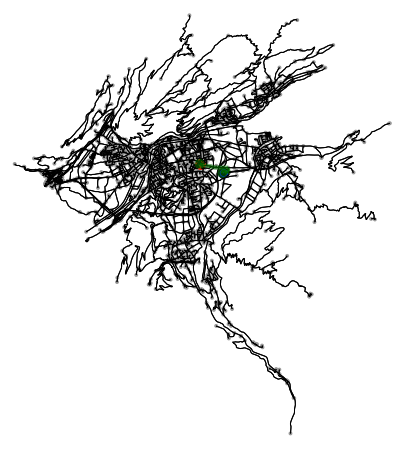

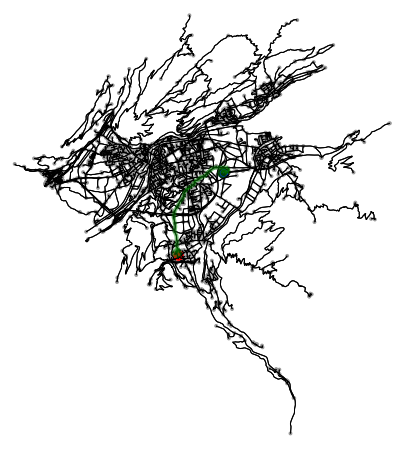

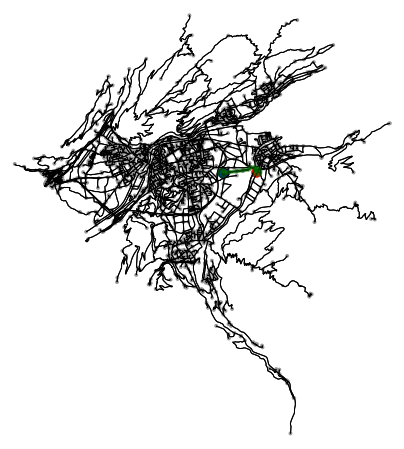

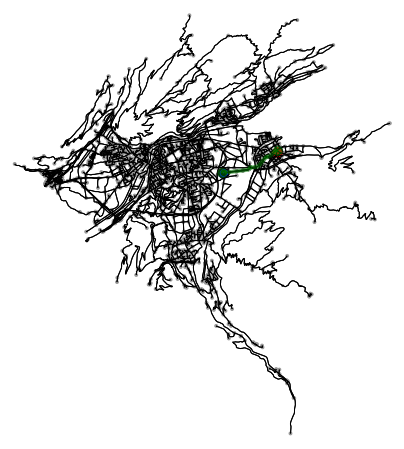

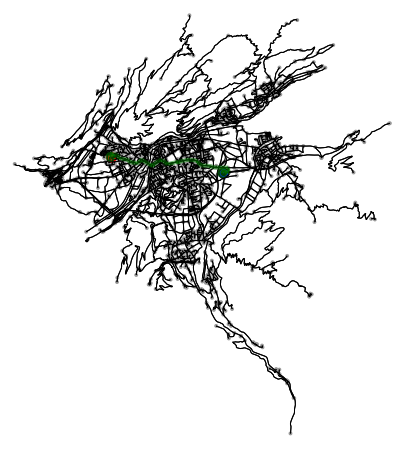

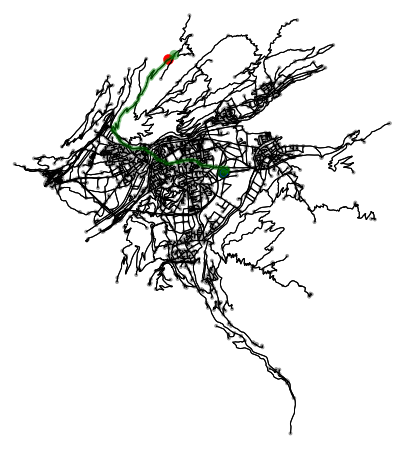

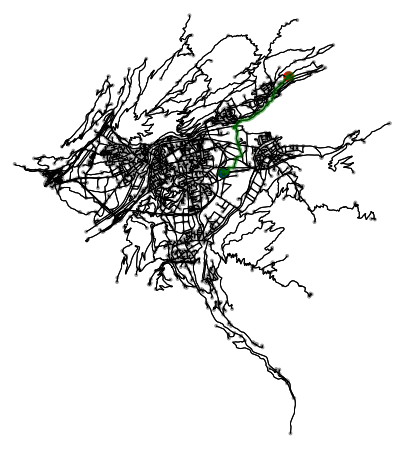

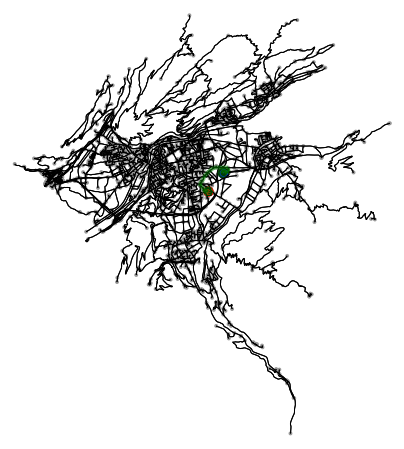

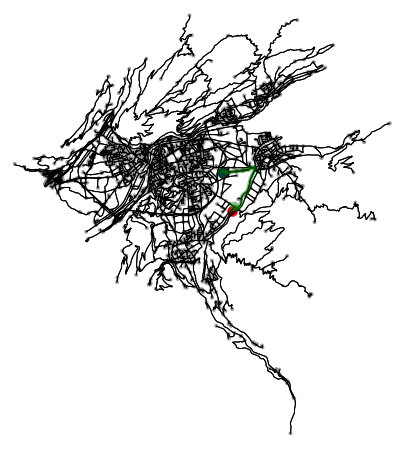

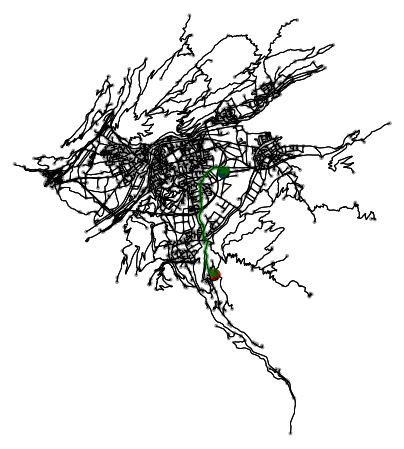

In [29]:
# Für jeden Bau werden die Wege zu den drei Bahnhöfen berechnet. Jede 1000. Route wird abgespeichert. 
f = 0
for index, row in df_gebäude.iterrows():
    try:
        print('\r' + str(round(100 * index / len(df_gebäude))), end='')
        punkt = row['zentrum']
        latlon = [punkt.y, punkt.x]

        # Der naheste Punkt auf einer Strasse wird berechnet. 
        closest_node_to_address = ox.utils.get_nearest_node(G, latlon)
        #print('closest:', closest_node_to_address)
        #print('closest latlon:', G.node[closest_node_to_address])

        # Der kürzeste Weg wird berechnet. 
        route = nx.shortest_path(G, closest_node_to_address, closest_node_to_mystery, weight='length')
        length = nx.shortest_path_length(G, closest_node_to_address, closest_node_to_mystery, weight='length')
        #print('length:', length)

        # Die Werte werden abgespeichert.
        df_gebäude.set_value(index, 'distanz_mystery', length)
        df_gebäude.set_value(index, 'lat', latlon[0])
        df_gebäude.set_value(index, 'lon', latlon[1])
        
        # Zur Kontrolle: Jede 1000. Berechnung wird visualisiert.
        if index % 1000 == 0:
            fig, ax = ox.plot_graph_route(G, route, fig_height=8, fig_width=8, 
                        show=False, close=False, 
                        edge_color='black',
                        orig_dest_node_color='green',
                        route_color='green')
            ax.scatter(latlon[1], latlon[0], c='red', s=100)
            ax.scatter(mystery[1], mystery[0], c='blue', s=100)
            plt.savefig('output/' + str(index) + '.svg')
            plt.savefig('output/' + str(index) + '.jpg', dpi=600)

        # Der kürzeste Weg zu den bestehenden Bahnhöfen wird berechnet. 
        length_westbahnhof = nx.shortest_path_length(G, closest_node_to_address, closest_node_to_westbahnhof, weight='length')
        df_gebäude.set_value(index, 'distanz_westbahnhof', length_westbahnhof)

        length_ostbahnhof = nx.shortest_path_length(G, closest_node_to_address, closest_node_to_ostbahnhof, weight='length')
        df_gebäude.set_value(index, 'distanz_ostbahnhof', length_ostbahnhof)
    
    except:
        f += 1

# Warnen, falls bei mehr als einem Prozent der Berechnungen Fehler auftreten. 
if f > len(df_gebäude) / 100:
    print('Bei über einem Prozent der Berechnungen sind Fehler aufgetreten. Bitte Berechnung kontrollieren.')

In [10]:
# Zur Kontrolle werden die Daten für jede 500. Berechnung ausgedruckt.  
df_gebäude[df_gebäude.index % 500 == 0][['lat', 'lon', 'distanz_westbahnhof', 'distanz_ostbahnhof', 'distanz_mystery']]

,lat,lon,distanz_westbahnhof,distanz_ostbahnhof,distanz_mystery
0,46.683152,7.850857,292.519,1690.665,2873.435
500,46.682847,7.853067,100.299,1631.499,2646.671
1000,46.684250,7.869332,1556.787,971.734,1175.688
1500,46.659431,7.865839,3234.657,4176.049,3917.356
2000,46.661568,7.861421,2772.742,3773.815,3709.477
2500,46.660484,7.867239,3298.888,3966.556,3707.863
3000,46.682289,7.889622,3367.719,2769.017,1244.484
3500,46.685542,7.897393,3945.093,2924.838,1821.858
4000,46.687039,7.897271,3961.661,2933.137,1838.426
4500,46.685962,7.849737,532.498,1801.712,3019.687


In [11]:
# Ein neuer DataFrame wird generiert. 
df = df_gebäude[['zentrum', 'geometry', 'addr:street', 'addr:housenumber', 'addr:postcode', 'addr:city', 'distanz_mystery', 'distanz_westbahnhof', 'distanz_ostbahnhof']]

In [12]:
# Wie viele Häuser sind verzeichnet? 
anzahlgebäude = len(df)
anzahlgebäude = round(anzahlgebäude,-2)
anzahlgebäude

10400

In [13]:
# Ein erster Blick auf die Daten. 
df.head()

,zentrum,geometry,addr:street,addr:housenumber,addr:postcode,addr:city,distanz_mystery,distanz_westbahnhof,distanz_ostbahnhof
0,POINT (7.850857063689771 46.68315205641377),"POLYGON ((7.8509678 46.6830792, 7.8509945 46.6...",Kanalpromenade,1,3800,Interlaken,2873.435,292.519,1690.665
1,POINT (7.852216032665059 46.68163585393115),"POLYGON ((7.8528857 46.6815175, 7.8522449 46.6...",Rugenparkstrasse,1,3800,Interlaken,2695.407,311.108,1841.018
2,POINT (7.852524626224199 46.6878025756984),"POLYGON ((7.8523507 46.687859, 7.8525235 46.68...",Spielmatte,13,3800,Unterseen,3006.811,746.863,1607.114
3,POINT (7.851543348123473 46.68254388616965),"POLYGON ((7.8517348 46.6829125, 7.851611 46.68...",Bahnhofstrasse,28,3800,Interlaken,2863.581,108.993,1680.811
4,POINT (7.854559205537513 46.68163246518183),"POLYGON ((7.8547809 46.68163, 7.8544823 46.681...",General-Guisan-Strasse,29,3800,Interlaken,2492.790,404.153,1638.401


In [14]:
# Auswertung: Welches ist der nächste Bahnhof?
df['bester_bahnhof'] = df[['distanz_mystery', 'distanz_westbahnhof', 'distanz_ostbahnhof']].idxmin(axis=1).str.replace('distanz_', '')
df_nächster_bahnhof = df.groupby(by='bester_bahnhof').count()[['zentrum']]
df_nächster_bahnhof

,zentrum
bester_bahnhof,
mystery,2935
ostbahnhof,1928
westbahnhof,5511


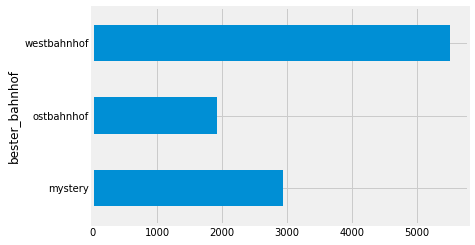

In [15]:
# Welches ist der nächste Bahnhof? Als Grafik.
df.groupby(by='bester_bahnhof').count()[['zentrum']].plot(kind='barh', legend=None)

In [16]:
# Mittlere Distanz zu den Bahnhöfen. 
mittlere_distanz = pd.DataFrame.median(df[['distanz_mystery', 'distanz_westbahnhof', 'distanz_ostbahnhof']])
mittlere_distanz

distanz_mystery        3030.470
distanz_westbahnhof    2544.946
distanz_ostbahnhof     2697.728
dtype: float64

In [17]:
# Weiteste Distanz zu den Bahnhöfen (in Metern).
weiteste_distanz = pd.DataFrame.max(df)
weiteste_distanz

distanz_mystery        10308.753
distanz_westbahnhof    10391.109
distanz_ostbahnhof     10646.604
dtype: float64

In [18]:
# Von welchem Haus aus ist die Distanz zum Bahnhof Mystery am grössten? 
df[df['distanz_mystery'] == df['distanz_mystery'].max()]

,zentrum,geometry,addr:street,addr:housenumber,addr:postcode,addr:city,distanz_mystery,distanz_westbahnhof,distanz_ostbahnhof,bester_bahnhof
10108,POINT (7.907060100000002 46.6559898),"POLYGON ((7.9070884 46.6559937, 7.9070578 46.6...",NaN,NaN,NaN,NaN,10308.753,10391.109,10646.604,mystery


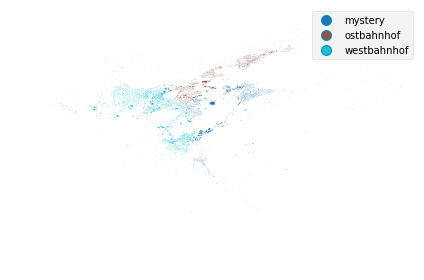

In [19]:
# Für wen ist welcher Bahnhof ideal? Die Karte mit den Gebäuden.
fig, ax = plt.subplots()
df = df.dropna(subset=['distanz_mystery'])
df.plot(column='bester_bahnhof', categorical=True, alpha=1, legend=True, ax=ax)
ax.grid(False)
plt.axis('off')
plt.tight_layout()
plt.savefig('output/bester_bahnhof.svg')
plt.savefig('output/bester_bahnhof.jpg', dpi=1200)
plt.show()

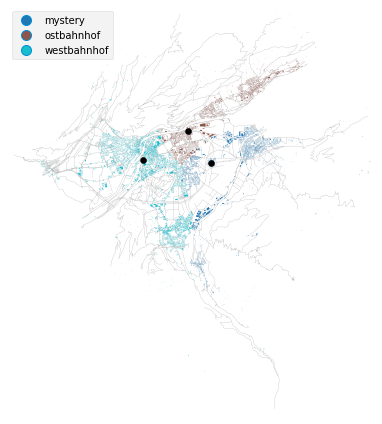

In [20]:
# Für wen ist welcher Bahnhof ideal? Die Karte mit den Gebäuden und den Strassen/ Wegen.
fig, ax = ox.plot_graph(G, show=False, close=False, node_color='none', node_size=0, node_edgecolor='none', edge_linewidth=0.1)
df = df.dropna(subset=['distanz_mystery'])
df.plot(column='bester_bahnhof', categorical=True, alpha=1, legend=True, ax=ax, zorder=3)
ax.grid(False)
plt.axis('off')

ax.scatter(ostbahnhof[1], ostbahnhof[0], color='black', zorder=3)
ax.scatter(westbahnhof[1], westbahnhof[0], color='black', zorder=3)    
ax.scatter(mystery[1], mystery[0], color='black', zorder=3)    
    
plt.tight_layout()
plt.savefig('output/bester_bahnhof_strassen.svg')
plt.savefig('output/bester_bahnhof_strassen.jpg', dpi=1200)
plt.show()

## Fazit
Die  beiden Interlakener Bahnhöfe liegen zentral. Entsprechend rasch sind sie von den meisten Orten auf dem Bödeli aus erreichbar. Der vorgeschlagene neue Standort hingegen befindet sich südöstlich davon. Damit ist er ideal für die Bewohner aus Bönigen, Matten und Wilderswil. Die Einwohner aus Teilen Interlakens und Unterseen müssten indes längere Wege in Kauf nehmen. 

Wir haben die Standorte der rund {{anzahlgebäude}} auf Openstreetmap verzeichneten Häusern in den Gemeinden {{', '.join([x.replace(', Bern, Switzerland', '') for x in places])}} heruntergeladen -- unabhängig davon, ob es sich dabei um Wohnhäuser, Gewerbebauten, Ställe oder Garagen handelt. In einem zweiten Schritt haben wir von jedem Haus aus den kürzesten Weg zu den bestehenden beiden Bahnhöfen sowie zum vorgeschlagenen neuen Standort Mystery errechnet. Berücksichtigt wurden alle öffentlichen und privaten Wegen und Strassen. Dabei wurde nicht unterschieden zwischen Fuss- und Velowegen sowie Autostrassen. Nicht einbezogen wurden zudem das Verkehrsaufkommen, die Topografie sowie allfällige andere Einschränkungen des Verkehrs. 

Interlaken West liegt gemäss diesen Berechnungen am zentralsten. Von über der Hälfte aller Häuser, {{df_nächster_bahnhof.loc['westbahnhof'][0]}} Bauten, ist dieser Bahnhof auf dem kürzesten Weg erreichbar. Interlaken Ost ist von {{df_nächster_bahnhof.loc['ostbahnhof'][0]}} Häusern aus der Bahnhof erster Wahl. Der neue Bahnhof Mystery wäre für die Bewohner aus {{df_nächster_bahnhof.loc['mystery'][0]}} Häusern die beste Option. Der vorgeschlagene Standort ist also besser erreichbar als der Bahnhof Interlaken Ost, jedoch schlechter als Interlaken West. 

Etwas anderes das Bild, wenn man sich die mittlere Distanz ansieht: Beim Westbahnhof liegt diese bei knapp zweieinhalb Kilometern, und beim Ostbahnhof bloss wenig darüber. Die mittlere Distanz zum Mystery-Bahnhof hingegen beträgt drei Kilometer. Der Hauptgrund: In der unmittelbaren Umgebung gibt es keine Wohnquartiere. 

Der grösste Nachteil des Bahnhofs Mystery ist zugleich der grösste Vorteil: Auf freiem Feld lässt sich leichter bauen. Und am Lärm stören sich höchstens die Kühe.

Datenauswertung: [Mathias Born](mailto:mathias.born@tamedia.ch?subject=Bahnhof Mystery)